In [1]:
from IPython.core.debugger import Tracer
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models
import argparse
from datetime import datetime
import os
import time
import multiprocessing
import psutil
import json
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  
import h5py
from sklearn.model_selection import train_test_split
from skimage.util import crop,  random_noise
from skimage.transform import   rescale, resize, rotate, AffineTransform, warp
import torch.optim as optim
from tqdm import tqdm
import copy
from collections import Counter
from PIL import Image
from pathlib import Path
import warnings
from monai.utils import ensure_tuple, optional_import
from IPython.core.debugger import Tracer
from copy import deepcopy
from monai.transforms.compose import Transform
from monai.transforms import \
    Compose, LoadPNG, AddChannel, ScaleIntensity, ToTensor, RandRotate, RandFlip, RandZoom
from monai.metrics import compute_roc_auc, compute_occlusion_sensitivity
from collections.abc import Sequence
from functools import partial
from typing import Dict, List, Optional, Sequence, Union

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import seaborn as sns
import random
from resnet18 import resnet18

In [2]:
data_dir = 'data/CellCycle'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
class_names.remove("PreprocessedTestData")
num_class = len(class_names)
all_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_files = [list(set([os.path.join(data_dir, class_name, x.split("_")[0]) 
                for x in os.listdir(os.path.join(data_dir, class_name))])) 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)
image_width, image_height = Image.open(all_files[0][0]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 32266
Image dimensions: 66 x 66
Label names: ['Anaphase', 'G1', 'G2', 'Metaphase', 'Prophase', 'S', 'Telophase']
Label counts: [15, 14333, 8601, 68, 606, 8616, 27]


In [3]:
weights = [1.0,1.1,1.4,1.5,1.3,1.4,1.0]

In [4]:
#flat_list = [item for sublist in all_files for item in sublist]

In [5]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [6]:
oversample = RandomOverSampler(random_state=42, sampling_strategy='all')

In [7]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []
X_train, testX, y_train, testY = train_test_split(image_file_list,image_label_list,test_size=test_frac, stratify=image_label_list, random_state=0)
trainX, valX, trainY, valY = train_test_split(X_train,y_train,test_size=valid_frac, stratify=y_train, random_state=1)
#dict(Counter(image_label_list))
print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 26135 Validation count = 2904 Test count = 3227


In [8]:
Counter(trainY)

Counter({1: 11610, 5: 6978, 2: 6967, 4: 490, 3: 55, 6: 22, 0: 13})

In [9]:
trainX, trainY = oversample.fit_resample(np.asarray(trainX).reshape(-1, 1), np.asarray(trainY))

In [10]:
Counter(trainY)

Counter({1: 11610, 5: 11610, 2: 11610, 4: 11610, 3: 11610, 6: 11610, 0: 11610})

In [11]:
Counter(testY)

Counter({2: 860, 1: 1433, 5: 862, 4: 61, 3: 7, 6: 3, 0: 1})

In [12]:
valX, valY = oversample.fit_resample(np.asarray(valX).reshape(-1, 1), np.asarray(valY))
#testX, testY = oversample.fit_resample(np.asarray(testX).reshape(-1, 1), np.asarray(testY))

In [13]:
Counter(testY)

Counter({2: 860, 1: 1433, 5: 862, 4: 61, 3: 7, 6: 3, 0: 1})

In [14]:
trainX[np.in1d(trainX, testX)]

array([], shape=(0, 1), dtype='<U30')

In [15]:
print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 81270 Validation count = 9030 Test count = 3227


x = []
y = []
for i in flat_list:
    im = Image.open(i)
    Tracer()()
    width, height = im.size
    x.append(width)
    y.append(height)
    if width != 66 or height != 66:
        print(i)
plt.scatter(x, y)
plt.show()

In [16]:
class LoadImage(Transform):
    """
    Load common 2D image format (PNG, JPG, etc. using PIL) file or files from provided path.
    If loading a list of files, stack them together and add a new dimension as first dimension,
    and use the meta data of the first image to represent the stacked result.
    It's based on the Image module in PIL library:
    https://pillow.readthedocs.io/en/stable/reference/Image.html
    """

    def __init__(self, only_channels = []) -> None:
        self.only_channels = only_channels

    def __call__(self, name: Union[Sequence[Union[Path, str]], Path, str]):
        if isinstance(name, (np.ndarray, np.generic)):
            name = name[0]
        img_array = list()
        class_dir = os.path.dirname(name)
        sample_id = os.path.basename(name) + "_Ch"
        channels = [np.asarray(Image.open(os.path.join(class_dir, file))) / 255. for file in os.listdir(class_dir) if file.startswith(sample_id)]
        #Tracer()()
        image = np.stack(channels, axis = 2)
        image_RGB = image * 255.
        return Image.fromarray(np.uint8(image_RGB))
        #img_array.append(image)
        #img_array = np.stack(img_array, axis=0) if len(img_array) > 1 else img_array[0]
        #return image

In [17]:
class ToTensorCustom(Transform):
    """
    Converts the input image to a tensor without applying any other transformations.
    """

    def __call__(self, img: Union[np.ndarray, torch.Tensor]) -> torch.Tensor:
        """
        Apply the transform to `img` and make it contiguous.
        """
        #img = np.asarray(img)
        #image = torch.from_numpy(copy.deepcopy(img))
        if torch.is_tensor(img):
            return img.contiguous().T
        #Tracer()()
        return torch.as_tensor(np.ascontiguousarray(img) / 255.).T

In [57]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.std = std
        self.mean = mean
        self.p = p
        
    def __call__(self, tensor):
        if torch.rand(1) < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [58]:
jurkat_mean = (0.1714, 0.0022, 0.3684)
jurkat_std = (0.0528, 0.0056, 0.0721)

train_transforms = transforms.Compose([
    LoadImage(),
    transforms.RandomCrop(64),
    transforms.RandomAffine(degrees=90, translate=(0.2,0.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((0,360)),
    ToTensorCustom(),
    transforms.RandomErasing(scale=(0.02,0.2), ratio=(0.3,0.9)),
    transforms.Normalize(jurkat_mean, jurkat_std)
    #AddGaussianNoise(0., 1., 0.3)
])
val_transforms = transforms.Compose([
    LoadImage(),
    ToTensorCustom()
])

In [59]:
train_transforms = transforms.Compose([
    LoadImage(),
    #transforms.RandomCrop(64),
    #transforms.RandomAffine(degrees=90, translate=(0.2,0.2)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((0,360)),
    ToTensorCustom(),
    #transforms.RandomErasing(scale=(0.02,0.2), ratio=(0.3,0.9)),
    #transforms.Normalize(jurkat_mean, jurkat_std)
    AddGaussianNoise(0., 1., 0.3)
])
val_transforms = transforms.Compose([
    LoadImage(),
    ToTensorCustom()
])

In [60]:
class JurkatDataset(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = JurkatDataset(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=300, shuffle=True, num_workers=10)

val_ds = JurkatDataset(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=300, num_workers=10)

test_ds = JurkatDataset(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=300, num_workers=10)

In [61]:
def plot_heatmap_3_channels(heatmap):
    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.imshow(heatmap[0])
    ax2.imshow(heatmap[1])
    ax3.imshow(heatmap[2])

data_dir = "/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/CellCycle/PreprocessedTestData"
for i,x in zip(np.arange(len(test_ds)), test_ds):
    #Tracer()()
    torch.save(x, os.path.join(data_dir, 'test_sample_{}.pt'.format(i)))
print("All test Data preprocessed and saved")

# Train

In [62]:
model = resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)

class_weights = torch.FloatTensor(weights).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)

class_weights = torch.FloatTensor(weights).to(device)

loss_function = nn.CrossEntropyLoss(weight=class_weights)

# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
#optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model.load_state_dict(torch.load('models/best_metric_model_jcd_oversampling_weightedCE.pth', map_location=torch.device(device))) 

In [63]:
epoch_num = 30
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
epoch_loss_valid_values = list()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device).float(), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            epoch_val_loss = 0
            step_val = 0
            for val_data in val_loader:
                step_val += 1
                val_images, val_labels = val_data[0].to(device).float(), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
                val_loss = loss_function(model(val_images), val_labels)
                epoch_val_loss += val_loss.item()
            epoch_val_loss /= step_val
            epoch_loss_valid_values.append(epoch_val_loss)
            print(f"epoch {epoch + 1} average validation loss: {epoch_val_loss:.4f}")
            #Tracer()()
            auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
            metric_values.append(auc_metric)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if auc_metric > best_metric:
                best_metric = auc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'models/best_metric_model_jcd_oversampling_weightedCE.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/30
1/270, train_loss: 2.1759
2/270, train_loss: 2.1170
3/270, train_loss: 2.2093
4/270, train_loss: 2.1913
5/270, train_loss: 2.1245
6/270, train_loss: 2.1804
7/270, train_loss: 2.1907
8/270, train_loss: 2.1064
9/270, train_loss: 2.0643
10/270, train_loss: 2.0431
11/270, train_loss: 2.0658
12/270, train_loss: 2.0948
13/270, train_loss: 2.0722
14/270, train_loss: 2.0386
15/270, train_loss: 1.9783
16/270, train_loss: 2.0466
17/270, train_loss: 1.9809
18/270, train_loss: 1.9660
19/270, train_loss: 1.9435
20/270, train_loss: 1.9539
21/270, train_loss: 1.9177
22/270, train_loss: 1.8886
23/270, train_loss: 1.9041
24/270, train_loss: 1.9243
25/270, train_loss: 1.9109
26/270, train_loss: 1.8123
27/270, train_loss: 1.9187
28/270, train_loss: 1.7895
29/270, train_loss: 1.8838
30/270, train_loss: 1.8603
31/270, train_loss: 1.8220
32/270, train_loss: 1.8121
33/270, train_loss: 1.7453
34/270, train_loss: 1.8853
35/270, train_loss: 1.7181
36/270, train_loss: 1.7218
37/270, train_l

20/270, train_loss: 0.9614
21/270, train_loss: 1.0760
22/270, train_loss: 0.9816
23/270, train_loss: 1.0686
24/270, train_loss: 1.0250
25/270, train_loss: 1.0769
26/270, train_loss: 0.9172
27/270, train_loss: 1.0178
28/270, train_loss: 0.9824
29/270, train_loss: 0.9562
30/270, train_loss: 0.9816
31/270, train_loss: 0.9854
32/270, train_loss: 1.0289
33/270, train_loss: 0.9049
34/270, train_loss: 0.9534
35/270, train_loss: 0.8816
36/270, train_loss: 0.9987
37/270, train_loss: 1.0219
38/270, train_loss: 1.0357
39/270, train_loss: 0.9192
40/270, train_loss: 0.9174
41/270, train_loss: 0.9651
42/270, train_loss: 0.9039
43/270, train_loss: 0.8782
44/270, train_loss: 0.9197
45/270, train_loss: 0.9328
46/270, train_loss: 1.0122
47/270, train_loss: 0.9802
48/270, train_loss: 0.9218
49/270, train_loss: 0.9330
50/270, train_loss: 0.9172
51/270, train_loss: 0.9467
52/270, train_loss: 0.9699
53/270, train_loss: 1.0244
54/270, train_loss: 0.9729
55/270, train_loss: 0.9867
56/270, train_loss: 1.0292
5

39/270, train_loss: 0.8472
40/270, train_loss: 0.8821
41/270, train_loss: 0.8407
42/270, train_loss: 0.7432
43/270, train_loss: 0.9305
44/270, train_loss: 0.7934
45/270, train_loss: 0.8264
46/270, train_loss: 0.8365
47/270, train_loss: 0.8237
48/270, train_loss: 0.8918
49/270, train_loss: 0.8277
50/270, train_loss: 0.9169
51/270, train_loss: 0.8769
52/270, train_loss: 0.7723
53/270, train_loss: 0.8076
54/270, train_loss: 0.9044
55/270, train_loss: 0.8561
56/270, train_loss: 0.8981
57/270, train_loss: 0.8175
58/270, train_loss: 0.8656
59/270, train_loss: 0.8188
60/270, train_loss: 0.8506
61/270, train_loss: 0.9824
62/270, train_loss: 0.8220
63/270, train_loss: 0.8248
64/270, train_loss: 0.8299
65/270, train_loss: 0.8350
66/270, train_loss: 0.8771
67/270, train_loss: 0.8411
68/270, train_loss: 0.8509
69/270, train_loss: 0.8402
70/270, train_loss: 0.7823
71/270, train_loss: 0.7984
72/270, train_loss: 0.7504
73/270, train_loss: 0.7962
74/270, train_loss: 0.7902
75/270, train_loss: 0.7867
7

58/270, train_loss: 0.8198
59/270, train_loss: 0.6614
60/270, train_loss: 0.6772
61/270, train_loss: 0.7310
62/270, train_loss: 0.7323
63/270, train_loss: 0.7948
64/270, train_loss: 0.7899
65/270, train_loss: 0.7049
66/270, train_loss: 0.7202
67/270, train_loss: 0.7745
68/270, train_loss: 0.7107
69/270, train_loss: 0.7988
70/270, train_loss: 0.7764
71/270, train_loss: 0.7117
72/270, train_loss: 0.6959
73/270, train_loss: 0.7039
74/270, train_loss: 0.7484
75/270, train_loss: 0.7507
76/270, train_loss: 0.6826
77/270, train_loss: 0.7596
78/270, train_loss: 0.8169
79/270, train_loss: 0.7682
80/270, train_loss: 0.7382
81/270, train_loss: 0.8652
82/270, train_loss: 0.7242
83/270, train_loss: 0.7519
84/270, train_loss: 0.7728
85/270, train_loss: 0.7683
86/270, train_loss: 0.7558
87/270, train_loss: 0.7480
88/270, train_loss: 0.7591
89/270, train_loss: 0.7731
90/270, train_loss: 0.7511
91/270, train_loss: 0.8204
92/270, train_loss: 0.6830
93/270, train_loss: 0.7419
94/270, train_loss: 0.7169
9

77/270, train_loss: 0.7657
78/270, train_loss: 0.5916
79/270, train_loss: 0.7312
80/270, train_loss: 0.6621
81/270, train_loss: 0.6556
82/270, train_loss: 0.7440
83/270, train_loss: 0.6782
84/270, train_loss: 0.6760
85/270, train_loss: 0.6877
86/270, train_loss: 0.7162
87/270, train_loss: 0.7788
88/270, train_loss: 0.6512
89/270, train_loss: 0.6253
90/270, train_loss: 0.7307
91/270, train_loss: 0.6966
92/270, train_loss: 0.7146
93/270, train_loss: 0.7335
94/270, train_loss: 0.7804
95/270, train_loss: 0.7816
96/270, train_loss: 0.7041
97/270, train_loss: 0.7441
98/270, train_loss: 0.6742
99/270, train_loss: 0.7160
100/270, train_loss: 0.7270
101/270, train_loss: 0.6583
102/270, train_loss: 0.6846
103/270, train_loss: 0.6658
104/270, train_loss: 0.6854
105/270, train_loss: 0.7490
106/270, train_loss: 0.7640
107/270, train_loss: 0.7493
108/270, train_loss: 0.6431
109/270, train_loss: 0.7768
110/270, train_loss: 0.6062
111/270, train_loss: 0.7050
112/270, train_loss: 0.7891
113/270, train_

96/270, train_loss: 0.5511
97/270, train_loss: 0.6658
98/270, train_loss: 0.6404
99/270, train_loss: 0.6878
100/270, train_loss: 0.5729
101/270, train_loss: 0.7917
102/270, train_loss: 0.6183
103/270, train_loss: 0.6056
104/270, train_loss: 0.7837
105/270, train_loss: 0.6369
106/270, train_loss: 0.7168
107/270, train_loss: 0.6127
108/270, train_loss: 0.6462
109/270, train_loss: 0.7123
110/270, train_loss: 0.6825
111/270, train_loss: 0.6300
112/270, train_loss: 0.6399
113/270, train_loss: 0.6453
114/270, train_loss: 0.5540
115/270, train_loss: 0.6061
116/270, train_loss: 0.7010
117/270, train_loss: 0.6294
118/270, train_loss: 0.6612
119/270, train_loss: 0.6944
120/270, train_loss: 0.6676
121/270, train_loss: 0.6378
122/270, train_loss: 0.6320
123/270, train_loss: 0.6236
124/270, train_loss: 0.6965
125/270, train_loss: 0.6356
126/270, train_loss: 0.5869
127/270, train_loss: 0.7921
128/270, train_loss: 0.6333
129/270, train_loss: 0.6213
130/270, train_loss: 0.6005
131/270, train_loss: 0.6

115/270, train_loss: 0.6144
116/270, train_loss: 0.5957
117/270, train_loss: 0.5729
118/270, train_loss: 0.6274
119/270, train_loss: 0.5262
120/270, train_loss: 0.6056
121/270, train_loss: 0.5970
122/270, train_loss: 0.6009
123/270, train_loss: 0.6199
124/270, train_loss: 0.6599
125/270, train_loss: 0.5205
126/270, train_loss: 0.6865
127/270, train_loss: 0.6372
128/270, train_loss: 0.6025
129/270, train_loss: 0.7236
130/270, train_loss: 0.5623
131/270, train_loss: 0.6811
132/270, train_loss: 0.6902
133/270, train_loss: 0.6328
134/270, train_loss: 0.5854
135/270, train_loss: 0.6031
136/270, train_loss: 0.6590
137/270, train_loss: 0.6190
138/270, train_loss: 0.5835
139/270, train_loss: 0.5790
140/270, train_loss: 0.6179
141/270, train_loss: 0.6042
142/270, train_loss: 0.6322
143/270, train_loss: 0.5722
144/270, train_loss: 0.5351
145/270, train_loss: 0.6958
146/270, train_loss: 0.6077
147/270, train_loss: 0.5908
148/270, train_loss: 0.6273
149/270, train_loss: 0.6711
150/270, train_loss:

134/270, train_loss: 0.5394
135/270, train_loss: 0.6047
136/270, train_loss: 0.6053
137/270, train_loss: 0.5639
138/270, train_loss: 0.5845
139/270, train_loss: 0.5841
140/270, train_loss: 0.6407
141/270, train_loss: 0.4724
142/270, train_loss: 0.4891
143/270, train_loss: 0.5986
144/270, train_loss: 0.6405
145/270, train_loss: 0.6697
146/270, train_loss: 0.6328
147/270, train_loss: 0.6241
148/270, train_loss: 0.6396
149/270, train_loss: 0.6655
150/270, train_loss: 0.5565
151/270, train_loss: 0.6122
152/270, train_loss: 0.6093
153/270, train_loss: 0.5784
154/270, train_loss: 0.6613
155/270, train_loss: 0.5787
156/270, train_loss: 0.5562
157/270, train_loss: 0.5807
158/270, train_loss: 0.6398
159/270, train_loss: 0.5911
160/270, train_loss: 0.5352
161/270, train_loss: 0.5685
162/270, train_loss: 0.5481
163/270, train_loss: 0.5944
164/270, train_loss: 0.5251
165/270, train_loss: 0.6454
166/270, train_loss: 0.6504
167/270, train_loss: 0.5737
168/270, train_loss: 0.7299
169/270, train_loss:

153/270, train_loss: 0.5785
154/270, train_loss: 0.6397
155/270, train_loss: 0.5373
156/270, train_loss: 0.5805
157/270, train_loss: 0.5212
158/270, train_loss: 0.5587
159/270, train_loss: 0.6335
160/270, train_loss: 0.6032
161/270, train_loss: 0.5297
162/270, train_loss: 0.5093
163/270, train_loss: 0.5398
164/270, train_loss: 0.5658
165/270, train_loss: 0.6110
166/270, train_loss: 0.6587
167/270, train_loss: 0.4907
168/270, train_loss: 0.6233
169/270, train_loss: 0.5695
170/270, train_loss: 0.5876
171/270, train_loss: 0.6284
172/270, train_loss: 0.4889
173/270, train_loss: 0.5925
174/270, train_loss: 0.5408
175/270, train_loss: 0.6633
176/270, train_loss: 0.5599
177/270, train_loss: 0.6887
178/270, train_loss: 0.4771
179/270, train_loss: 0.5039
180/270, train_loss: 0.5343
181/270, train_loss: 0.6198
182/270, train_loss: 0.6371
183/270, train_loss: 0.5157
184/270, train_loss: 0.5488
185/270, train_loss: 0.6011
186/270, train_loss: 0.6165
187/270, train_loss: 0.5718
188/270, train_loss:

172/270, train_loss: 0.5879
173/270, train_loss: 0.6227
174/270, train_loss: 0.6395
175/270, train_loss: 0.6004
176/270, train_loss: 0.5629
177/270, train_loss: 0.5289
178/270, train_loss: 0.6084
179/270, train_loss: 0.5634
180/270, train_loss: 0.5818
181/270, train_loss: 0.5400
182/270, train_loss: 0.5086
183/270, train_loss: 0.6220
184/270, train_loss: 0.5190
185/270, train_loss: 0.6379
186/270, train_loss: 0.5732
187/270, train_loss: 0.5670
188/270, train_loss: 0.6317
189/270, train_loss: 0.6276
190/270, train_loss: 0.5111
191/270, train_loss: 0.5825
192/270, train_loss: 0.6044
193/270, train_loss: 0.5198
194/270, train_loss: 0.5486
195/270, train_loss: 0.6153
196/270, train_loss: 0.5418
197/270, train_loss: 0.5587
198/270, train_loss: 0.6067
199/270, train_loss: 0.6301
200/270, train_loss: 0.6174
201/270, train_loss: 0.5937
202/270, train_loss: 0.6516
203/270, train_loss: 0.6168
204/270, train_loss: 0.5836
205/270, train_loss: 0.6218
206/270, train_loss: 0.5937
207/270, train_loss:

191/270, train_loss: 0.5066
192/270, train_loss: 0.5487
193/270, train_loss: 0.5674
194/270, train_loss: 0.6406
195/270, train_loss: 0.5299
196/270, train_loss: 0.5396
197/270, train_loss: 0.5189
198/270, train_loss: 0.4987
199/270, train_loss: 0.4867
200/270, train_loss: 0.5537
201/270, train_loss: 0.5217
202/270, train_loss: 0.5481
203/270, train_loss: 0.4840
204/270, train_loss: 0.5576
205/270, train_loss: 0.6214
206/270, train_loss: 0.5125
207/270, train_loss: 0.5893
208/270, train_loss: 0.6379
209/270, train_loss: 0.5774
210/270, train_loss: 0.5831
211/270, train_loss: 0.5251
212/270, train_loss: 0.5858
213/270, train_loss: 0.5402
214/270, train_loss: 0.5599
215/270, train_loss: 0.5865
216/270, train_loss: 0.6035
217/270, train_loss: 0.5259
218/270, train_loss: 0.5800
219/270, train_loss: 0.5447
220/270, train_loss: 0.5724
221/270, train_loss: 0.5827
222/270, train_loss: 0.6288
223/270, train_loss: 0.6258
224/270, train_loss: 0.5717
225/270, train_loss: 0.5074
226/270, train_loss:

210/270, train_loss: 0.5966
211/270, train_loss: 0.5511
212/270, train_loss: 0.5519
213/270, train_loss: 0.4941
214/270, train_loss: 0.5802
215/270, train_loss: 0.5585
216/270, train_loss: 0.5215
217/270, train_loss: 0.6036
218/270, train_loss: 0.5376
219/270, train_loss: 0.5938
220/270, train_loss: 0.5880
221/270, train_loss: 0.5351
222/270, train_loss: 0.5735
223/270, train_loss: 0.6041
224/270, train_loss: 0.5089
225/270, train_loss: 0.5207
226/270, train_loss: 0.5237
227/270, train_loss: 0.5652
228/270, train_loss: 0.5539
229/270, train_loss: 0.5544
230/270, train_loss: 0.5897
231/270, train_loss: 0.5164
232/270, train_loss: 0.5648
233/270, train_loss: 0.5438
234/270, train_loss: 0.5012
235/270, train_loss: 0.6096
236/270, train_loss: 0.5004
237/270, train_loss: 0.4881
238/270, train_loss: 0.5401
239/270, train_loss: 0.4556
240/270, train_loss: 0.6068
241/270, train_loss: 0.5373
242/270, train_loss: 0.4366
243/270, train_loss: 0.5545
244/270, train_loss: 0.5921
245/270, train_loss:

229/270, train_loss: 0.5224
230/270, train_loss: 0.5469
231/270, train_loss: 0.4881
232/270, train_loss: 0.5390
233/270, train_loss: 0.6306
234/270, train_loss: 0.5141
235/270, train_loss: 0.5632
236/270, train_loss: 0.5485
237/270, train_loss: 0.4609
238/270, train_loss: 0.5458
239/270, train_loss: 0.4849
240/270, train_loss: 0.5487
241/270, train_loss: 0.5919
242/270, train_loss: 0.5338
243/270, train_loss: 0.5584
244/270, train_loss: 0.5349
245/270, train_loss: 0.6418
246/270, train_loss: 0.5855
247/270, train_loss: 0.4833
248/270, train_loss: 0.5159
249/270, train_loss: 0.5243
250/270, train_loss: 0.5402
251/270, train_loss: 0.5985
252/270, train_loss: 0.5255
253/270, train_loss: 0.5188
254/270, train_loss: 0.6334
255/270, train_loss: 0.5812
256/270, train_loss: 0.5967
257/270, train_loss: 0.5500
258/270, train_loss: 0.5745
259/270, train_loss: 0.5313
260/270, train_loss: 0.5549
261/270, train_loss: 0.6426
262/270, train_loss: 0.5238
263/270, train_loss: 0.5723
264/270, train_loss:

248/270, train_loss: 0.5364
249/270, train_loss: 0.4579
250/270, train_loss: 0.5192
251/270, train_loss: 0.5976
252/270, train_loss: 0.5517
253/270, train_loss: 0.5430
254/270, train_loss: 0.4476
255/270, train_loss: 0.5016
256/270, train_loss: 0.5247
257/270, train_loss: 0.4782
258/270, train_loss: 0.5650
259/270, train_loss: 0.6408
260/270, train_loss: 0.4912
261/270, train_loss: 0.5228
262/270, train_loss: 0.6113
263/270, train_loss: 0.6075
264/270, train_loss: 0.5552
265/270, train_loss: 0.6361
266/270, train_loss: 0.4717
267/270, train_loss: 0.5280
268/270, train_loss: 0.5720
269/270, train_loss: 0.5171
270/270, train_loss: 0.5588
271/270, train_loss: 0.5750
epoch 14 average loss: 0.5354
epoch 14 average validation loss: 0.6569
current epoch: 14 current AUC: 0.9595 current accuracy: 0.8127 best AUC: 0.9684 at epoch: 6
----------
epoch 15/30
1/270, train_loss: 0.5760
2/270, train_loss: 0.5115
3/270, train_loss: 0.4490
4/270, train_loss: 0.5762
5/270, train_loss: 0.5510
6/270, train

267/270, train_loss: 0.6231
268/270, train_loss: 0.5363
269/270, train_loss: 0.4862
270/270, train_loss: 0.4930
271/270, train_loss: 0.5094
epoch 15 average loss: 0.5298
epoch 15 average validation loss: 0.6202
current epoch: 15 current AUC: 0.9617 current accuracy: 0.8042 best AUC: 0.9684 at epoch: 6
----------
epoch 16/30
1/270, train_loss: 0.5427
2/270, train_loss: 0.5066
3/270, train_loss: 0.5200
4/270, train_loss: 0.5962
5/270, train_loss: 0.5123
6/270, train_loss: 0.4592
7/270, train_loss: 0.5138
8/270, train_loss: 0.4735
9/270, train_loss: 0.6174
10/270, train_loss: 0.5121
11/270, train_loss: 0.4690
12/270, train_loss: 0.5463
13/270, train_loss: 0.5616
14/270, train_loss: 0.5610
15/270, train_loss: 0.5153
16/270, train_loss: 0.5069
17/270, train_loss: 0.5122
18/270, train_loss: 0.5229
19/270, train_loss: 0.5528
20/270, train_loss: 0.5158
21/270, train_loss: 0.4685
22/270, train_loss: 0.5569
23/270, train_loss: 0.5225
24/270, train_loss: 0.4685
25/270, train_loss: 0.4929
26/270, 

9/270, train_loss: 0.5070
10/270, train_loss: 0.6480
11/270, train_loss: 0.4867
12/270, train_loss: 0.4852
13/270, train_loss: 0.5163
14/270, train_loss: 0.5835
15/270, train_loss: 0.4946
16/270, train_loss: 0.4770
17/270, train_loss: 0.5445
18/270, train_loss: 0.5349
19/270, train_loss: 0.4849
20/270, train_loss: 0.4997
21/270, train_loss: 0.4832
22/270, train_loss: 0.5248
23/270, train_loss: 0.5098
24/270, train_loss: 0.4437
25/270, train_loss: 0.4835
26/270, train_loss: 0.5633
27/270, train_loss: 0.5021
28/270, train_loss: 0.5196
29/270, train_loss: 0.4586
30/270, train_loss: 0.5061
31/270, train_loss: 0.5080
32/270, train_loss: 0.4836
33/270, train_loss: 0.5460
34/270, train_loss: 0.5587
35/270, train_loss: 0.5360
36/270, train_loss: 0.4595
37/270, train_loss: 0.5208
38/270, train_loss: 0.5664
39/270, train_loss: 0.4765
40/270, train_loss: 0.5491
41/270, train_loss: 0.4658
42/270, train_loss: 0.5037
43/270, train_loss: 0.5080
44/270, train_loss: 0.5696
45/270, train_loss: 0.4577
46

29/270, train_loss: 0.4672
30/270, train_loss: 0.6027
31/270, train_loss: 0.4894
32/270, train_loss: 0.5021
33/270, train_loss: 0.5046
34/270, train_loss: 0.5323
35/270, train_loss: 0.5383
36/270, train_loss: 0.6015
37/270, train_loss: 0.4220
38/270, train_loss: 0.4877
39/270, train_loss: 0.4076
40/270, train_loss: 0.5391
41/270, train_loss: 0.5325
42/270, train_loss: 0.4562
43/270, train_loss: 0.5182
44/270, train_loss: 0.5247
45/270, train_loss: 0.5508
46/270, train_loss: 0.5145
47/270, train_loss: 0.4328
48/270, train_loss: 0.4741
49/270, train_loss: 0.5084
50/270, train_loss: 0.4852
51/270, train_loss: 0.4535
52/270, train_loss: 0.4938
53/270, train_loss: 0.5441
54/270, train_loss: 0.4775
55/270, train_loss: 0.5614
56/270, train_loss: 0.4569
57/270, train_loss: 0.5938
58/270, train_loss: 0.5064
59/270, train_loss: 0.5869
60/270, train_loss: 0.5532
61/270, train_loss: 0.6100
62/270, train_loss: 0.4916
63/270, train_loss: 0.4697
64/270, train_loss: 0.5821
65/270, train_loss: 0.5107
6

49/270, train_loss: 0.4759
50/270, train_loss: 0.5331
51/270, train_loss: 0.4992
52/270, train_loss: 0.5841
53/270, train_loss: 0.4802
54/270, train_loss: 0.4846
55/270, train_loss: 0.5173
56/270, train_loss: 0.5220
57/270, train_loss: 0.5016
58/270, train_loss: 0.4514
59/270, train_loss: 0.4678
60/270, train_loss: 0.5423
61/270, train_loss: 0.5429
62/270, train_loss: 0.4886
63/270, train_loss: 0.5356
64/270, train_loss: 0.4709
65/270, train_loss: 0.5043
66/270, train_loss: 0.5761
67/270, train_loss: 0.5420
68/270, train_loss: 0.5397
69/270, train_loss: 0.5177
70/270, train_loss: 0.5328
71/270, train_loss: 0.4895
72/270, train_loss: 0.5014
73/270, train_loss: 0.5084
74/270, train_loss: 0.4764
75/270, train_loss: 0.4745
76/270, train_loss: 0.4249
77/270, train_loss: 0.4819
78/270, train_loss: 0.5121
79/270, train_loss: 0.5061
80/270, train_loss: 0.5361
81/270, train_loss: 0.5191
82/270, train_loss: 0.4977
83/270, train_loss: 0.4687
84/270, train_loss: 0.4732
85/270, train_loss: 0.5143
8

69/270, train_loss: 0.4977
70/270, train_loss: 0.5529
71/270, train_loss: 0.4537
72/270, train_loss: 0.4706
73/270, train_loss: 0.4785
74/270, train_loss: 0.5007
75/270, train_loss: 0.4818
76/270, train_loss: 0.4719
77/270, train_loss: 0.5103
78/270, train_loss: 0.4390
79/270, train_loss: 0.4996
80/270, train_loss: 0.5436
81/270, train_loss: 0.4631
82/270, train_loss: 0.4230
83/270, train_loss: 0.5388
84/270, train_loss: 0.4282
85/270, train_loss: 0.5108
86/270, train_loss: 0.4987
87/270, train_loss: 0.5666
88/270, train_loss: 0.4685
89/270, train_loss: 0.4247
90/270, train_loss: 0.5020
91/270, train_loss: 0.5740
92/270, train_loss: 0.4849
93/270, train_loss: 0.5011
94/270, train_loss: 0.5256
95/270, train_loss: 0.4723
96/270, train_loss: 0.5611
97/270, train_loss: 0.4415
98/270, train_loss: 0.6006
99/270, train_loss: 0.4619
100/270, train_loss: 0.3820
101/270, train_loss: 0.4862
102/270, train_loss: 0.4807
103/270, train_loss: 0.5442
104/270, train_loss: 0.5467
105/270, train_loss: 0.

89/270, train_loss: 0.4182
90/270, train_loss: 0.4939
91/270, train_loss: 0.5012
92/270, train_loss: 0.4709
93/270, train_loss: 0.4269
94/270, train_loss: 0.5170
95/270, train_loss: 0.4488
96/270, train_loss: 0.5530
97/270, train_loss: 0.4899
98/270, train_loss: 0.5233
99/270, train_loss: 0.4549
100/270, train_loss: 0.4761
101/270, train_loss: 0.5024
102/270, train_loss: 0.4987
103/270, train_loss: 0.5078
104/270, train_loss: 0.4790
105/270, train_loss: 0.5250
106/270, train_loss: 0.5113
107/270, train_loss: 0.4698
108/270, train_loss: 0.5352
109/270, train_loss: 0.5382
110/270, train_loss: 0.5089
111/270, train_loss: 0.4659
112/270, train_loss: 0.5024
113/270, train_loss: 0.4353
114/270, train_loss: 0.4677
115/270, train_loss: 0.4720
116/270, train_loss: 0.4959
117/270, train_loss: 0.4480
118/270, train_loss: 0.4568
119/270, train_loss: 0.4976
120/270, train_loss: 0.4156
121/270, train_loss: 0.4849
122/270, train_loss: 0.4623
123/270, train_loss: 0.4874
124/270, train_loss: 0.4743
125

109/270, train_loss: 0.4658
110/270, train_loss: 0.5010
111/270, train_loss: 0.5102
112/270, train_loss: 0.4456
113/270, train_loss: 0.5122
114/270, train_loss: 0.4755
115/270, train_loss: 0.5398
116/270, train_loss: 0.5339
117/270, train_loss: 0.5074
118/270, train_loss: 0.5557
119/270, train_loss: 0.4995
120/270, train_loss: 0.5569
121/270, train_loss: 0.4269
122/270, train_loss: 0.5232
123/270, train_loss: 0.4684
124/270, train_loss: 0.3953
125/270, train_loss: 0.4783
126/270, train_loss: 0.5254
127/270, train_loss: 0.4870
128/270, train_loss: 0.4981
129/270, train_loss: 0.4847
130/270, train_loss: 0.5302
131/270, train_loss: 0.5266
132/270, train_loss: 0.4639
133/270, train_loss: 0.4830
134/270, train_loss: 0.4687
135/270, train_loss: 0.4101
136/270, train_loss: 0.4595
137/270, train_loss: 0.4613
138/270, train_loss: 0.4373
139/270, train_loss: 0.4840
140/270, train_loss: 0.5765
141/270, train_loss: 0.4155
142/270, train_loss: 0.5078
143/270, train_loss: 0.4345
144/270, train_loss:

128/270, train_loss: 0.4844
129/270, train_loss: 0.5687
130/270, train_loss: 0.4866
131/270, train_loss: 0.4909
132/270, train_loss: 0.4482
133/270, train_loss: 0.4785
134/270, train_loss: 0.4409
135/270, train_loss: 0.5171
136/270, train_loss: 0.5130
137/270, train_loss: 0.4798
138/270, train_loss: 0.4126
139/270, train_loss: 0.4703
140/270, train_loss: 0.5021
141/270, train_loss: 0.4434
142/270, train_loss: 0.4690
143/270, train_loss: 0.4754
144/270, train_loss: 0.5196
145/270, train_loss: 0.4671
146/270, train_loss: 0.5180
147/270, train_loss: 0.5481
148/270, train_loss: 0.4967
149/270, train_loss: 0.5092
150/270, train_loss: 0.5020
151/270, train_loss: 0.5240
152/270, train_loss: 0.5127
153/270, train_loss: 0.5044
154/270, train_loss: 0.4175
155/270, train_loss: 0.4385
156/270, train_loss: 0.4192
157/270, train_loss: 0.4289
158/270, train_loss: 0.4391
159/270, train_loss: 0.5000
160/270, train_loss: 0.4518
161/270, train_loss: 0.4501
162/270, train_loss: 0.5046
163/270, train_loss:

147/270, train_loss: 0.4375
148/270, train_loss: 0.4338
149/270, train_loss: 0.5032
150/270, train_loss: 0.5500
151/270, train_loss: 0.5032
152/270, train_loss: 0.4543
153/270, train_loss: 0.4314
154/270, train_loss: 0.4097
155/270, train_loss: 0.4900
156/270, train_loss: 0.5480
157/270, train_loss: 0.5047
158/270, train_loss: 0.4991
159/270, train_loss: 0.4214
160/270, train_loss: 0.5108
161/270, train_loss: 0.4781
162/270, train_loss: 0.5187
163/270, train_loss: 0.4435
164/270, train_loss: 0.4942
165/270, train_loss: 0.4604
166/270, train_loss: 0.5025
167/270, train_loss: 0.5447
168/270, train_loss: 0.4714
169/270, train_loss: 0.4473
170/270, train_loss: 0.4033
171/270, train_loss: 0.4308
172/270, train_loss: 0.4351
173/270, train_loss: 0.4258
174/270, train_loss: 0.4239
175/270, train_loss: 0.5352
176/270, train_loss: 0.5106
177/270, train_loss: 0.5050
178/270, train_loss: 0.5656
179/270, train_loss: 0.4335
180/270, train_loss: 0.4360
181/270, train_loss: 0.4943
182/270, train_loss:

166/270, train_loss: 0.4538
167/270, train_loss: 0.4612
168/270, train_loss: 0.4147
169/270, train_loss: 0.4306
170/270, train_loss: 0.4021
171/270, train_loss: 0.5062
172/270, train_loss: 0.4896
173/270, train_loss: 0.4751
174/270, train_loss: 0.4795
175/270, train_loss: 0.4108
176/270, train_loss: 0.4735
177/270, train_loss: 0.5164
178/270, train_loss: 0.4907
179/270, train_loss: 0.4541
180/270, train_loss: 0.4570
181/270, train_loss: 0.5183
182/270, train_loss: 0.4779
183/270, train_loss: 0.5263
184/270, train_loss: 0.4709
185/270, train_loss: 0.4640
186/270, train_loss: 0.4618
187/270, train_loss: 0.5156
188/270, train_loss: 0.4646
189/270, train_loss: 0.4796
190/270, train_loss: 0.4261
191/270, train_loss: 0.4236
192/270, train_loss: 0.4272
193/270, train_loss: 0.3817
194/270, train_loss: 0.4297
195/270, train_loss: 0.4576
196/270, train_loss: 0.4350
197/270, train_loss: 0.4670
198/270, train_loss: 0.4835
199/270, train_loss: 0.4638
200/270, train_loss: 0.4852
201/270, train_loss:

185/270, train_loss: 0.4334
186/270, train_loss: 0.4722
187/270, train_loss: 0.4464
188/270, train_loss: 0.5070
189/270, train_loss: 0.4622
190/270, train_loss: 0.5435
191/270, train_loss: 0.4891
192/270, train_loss: 0.4595
193/270, train_loss: 0.4487
194/270, train_loss: 0.4321
195/270, train_loss: 0.4261
196/270, train_loss: 0.4550
197/270, train_loss: 0.4541
198/270, train_loss: 0.4481
199/270, train_loss: 0.5249
200/270, train_loss: 0.4593
201/270, train_loss: 0.3973
202/270, train_loss: 0.4596
203/270, train_loss: 0.4614
204/270, train_loss: 0.5069
205/270, train_loss: 0.4776
206/270, train_loss: 0.4204
207/270, train_loss: 0.5459
208/270, train_loss: 0.5193
209/270, train_loss: 0.5525
210/270, train_loss: 0.4474
211/270, train_loss: 0.4634
212/270, train_loss: 0.4545
213/270, train_loss: 0.4788
214/270, train_loss: 0.4776
215/270, train_loss: 0.4707
216/270, train_loss: 0.5512
217/270, train_loss: 0.4833
218/270, train_loss: 0.4448
219/270, train_loss: 0.4645
220/270, train_loss:

204/270, train_loss: 0.5112
205/270, train_loss: 0.4838
206/270, train_loss: 0.4154
207/270, train_loss: 0.4500
208/270, train_loss: 0.4606
209/270, train_loss: 0.5236
210/270, train_loss: 0.4854
211/270, train_loss: 0.4999
212/270, train_loss: 0.4709
213/270, train_loss: 0.4263
214/270, train_loss: 0.4307
215/270, train_loss: 0.4728
216/270, train_loss: 0.4929
217/270, train_loss: 0.5031
218/270, train_loss: 0.4709
219/270, train_loss: 0.4869
220/270, train_loss: 0.4531
221/270, train_loss: 0.4568
222/270, train_loss: 0.4289
223/270, train_loss: 0.5033
224/270, train_loss: 0.4659
225/270, train_loss: 0.4345
226/270, train_loss: 0.5332
227/270, train_loss: 0.4630
228/270, train_loss: 0.4858
229/270, train_loss: 0.4578
230/270, train_loss: 0.4549
231/270, train_loss: 0.4150
232/270, train_loss: 0.4781
233/270, train_loss: 0.4704
234/270, train_loss: 0.4350
235/270, train_loss: 0.4736
236/270, train_loss: 0.4509
237/270, train_loss: 0.4705
238/270, train_loss: 0.4089
239/270, train_loss:

223/270, train_loss: 0.3897
224/270, train_loss: 0.4840
225/270, train_loss: 0.5044
226/270, train_loss: 0.4325
227/270, train_loss: 0.4513
228/270, train_loss: 0.5169
229/270, train_loss: 0.4698
230/270, train_loss: 0.4860
231/270, train_loss: 0.4921
232/270, train_loss: 0.4408
233/270, train_loss: 0.4639
234/270, train_loss: 0.5001
235/270, train_loss: 0.3642
236/270, train_loss: 0.4557
237/270, train_loss: 0.4305
238/270, train_loss: 0.4659
239/270, train_loss: 0.4570
240/270, train_loss: 0.4969
241/270, train_loss: 0.4071
242/270, train_loss: 0.4609
243/270, train_loss: 0.4582
244/270, train_loss: 0.4861
245/270, train_loss: 0.5089
246/270, train_loss: 0.4440
247/270, train_loss: 0.4711
248/270, train_loss: 0.4978
249/270, train_loss: 0.4215
250/270, train_loss: 0.5272
251/270, train_loss: 0.4723
252/270, train_loss: 0.4451
253/270, train_loss: 0.4742
254/270, train_loss: 0.4865
255/270, train_loss: 0.3782
256/270, train_loss: 0.3372
257/270, train_loss: 0.4882
258/270, train_loss:

242/270, train_loss: 0.3700
243/270, train_loss: 0.4624
244/270, train_loss: 0.4331
245/270, train_loss: 0.5063
246/270, train_loss: 0.4072
247/270, train_loss: 0.4342
248/270, train_loss: 0.4432
249/270, train_loss: 0.4508
250/270, train_loss: 0.4935
251/270, train_loss: 0.4723
252/270, train_loss: 0.5257
253/270, train_loss: 0.4770
254/270, train_loss: 0.5012
255/270, train_loss: 0.4399
256/270, train_loss: 0.4407
257/270, train_loss: 0.4927
258/270, train_loss: 0.4497
259/270, train_loss: 0.4722
260/270, train_loss: 0.4864
261/270, train_loss: 0.4551
262/270, train_loss: 0.4906
263/270, train_loss: 0.5455
264/270, train_loss: 0.3933
265/270, train_loss: 0.4799
266/270, train_loss: 0.4124
267/270, train_loss: 0.4711
268/270, train_loss: 0.3835
269/270, train_loss: 0.3934
270/270, train_loss: 0.3835
271/270, train_loss: 0.4568
epoch 29 average loss: 0.4564
epoch 29 average validation loss: 0.7779
current epoch: 29 current AUC: 0.9560 current accuracy: 0.7836 best AUC: 0.9684 at epoch:

261/270, train_loss: 0.4233
262/270, train_loss: 0.4305
263/270, train_loss: 0.5360
264/270, train_loss: 0.4828
265/270, train_loss: 0.3912
266/270, train_loss: 0.3690
267/270, train_loss: 0.3887
268/270, train_loss: 0.4634
269/270, train_loss: 0.4169
270/270, train_loss: 0.5254
271/270, train_loss: 0.4998
epoch 30 average loss: 0.4535
epoch 30 average validation loss: 0.6289
current epoch: 30 current AUC: 0.9632 current accuracy: 0.8076 best AUC: 0.9684 at epoch: 6
train completed, best_metric: 0.9684 at epoch: 6


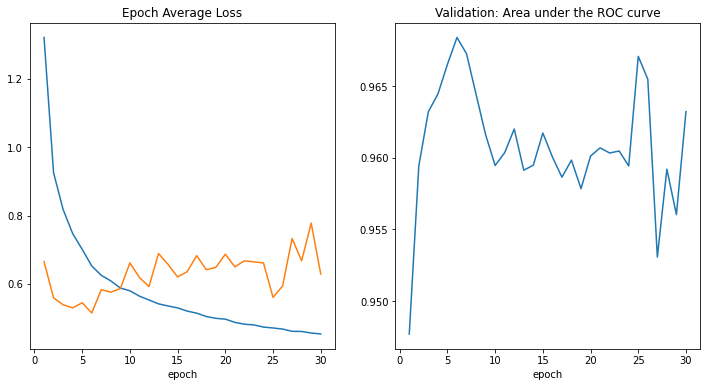

In [65]:
plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
y2 = epoch_loss_valid_values
plt.xlabel('epoch')
plt.plot(x, y, label="training error")
plt.plot(x, y2, label="validation error")
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

plt.figure('train', (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation: Area under the ROC curve")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

# Evaluating

In [66]:
model = resnet18(pretrained=True)
device = "cpu"
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# change first layer
#model_ft.conv1 = torch.nn.Conv2d(64, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)

model = model.to(device)
model.load_state_dict(torch.load('models/best_metric_model_jcd_oversampling_weightedCE.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [67]:
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    Anaphase     0.2000    1.0000    0.3333         1
          G1     0.8776    0.7906    0.8319      1433
          G2     0.7702    0.6198    0.6869       860
   Metaphase     0.4000    0.8571    0.5455         7
    Prophase     0.2246    0.6885    0.3387        61
           S     0.5537    0.6636    0.6037       862
   Telophase     0.7500    1.0000    0.8571         3

    accuracy                         0.7096      3227
   macro avg     0.5395    0.8028    0.5996      3227
weighted avg     0.7488    0.7096    0.7222      3227



In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, caption=""):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix ' + caption
        else:
            title = 'Confusion matrix, without normalization ' + caption

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix" + caption)
    else:
        print('Confusion matrix, without normalization' + caption)

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.79064899 0.00697837 0.         0.00139567 0.20097697
  0.        ]
 [0.00348837 0.0244186  0.61976744 0.00232558 0.15232558 0.19767442
  0.        ]
 [0.         0.         0.         0.85714286 0.         0.14285714
  0.        ]
 [0.01639344 0.         0.18032787 0.08196721 0.68852459 0.03278689
  0.        ]
 [0.         0.15893271 0.16009281 0.00232019 0.01392111 0.66357309
  0.00116009]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


<AxesSubplot:title={'center':'Normalized confusion matrix '}, xlabel='Predicted label', ylabel='True label'>

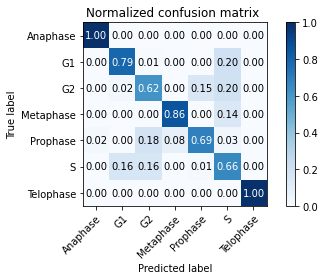

In [70]:
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True)

In [71]:
import random
from collections.abc import Sequence
from functools import partial
from typing import Optional, Union
from scipy.special import softmax

def pixel_permutation_per_channel(
    model: nn.Module,
    images: torch.Tensor,
    labels: Union[int, torch.Tensor],
) -> np.ndarray:

    # Get baseline probability
    baselines = softmax(model(images), axis=1).detach()[np.arange(len(labels)),labels]
    #iterate through the channels
    res = []
    for i in range(images[0].shape[0]):
        #iterate through the images in batch
        im_stack = []
        for image in images:
            im = copy.deepcopy(image)
            channel_shape = im[i].shape
            arr = copy.deepcopy(im[i].flatten().detach())
            random.shuffle(arr)
            im[i] = arr.reshape(channel_shape)
            im_stack.append(im.unsqueeze(0))
        im_stack = torch.cat(im_stack) # batch with shuffled i channel
        #Tracer()()
        probabilities = softmax(model(im_stack), axis=1)
        probs_for_label = probabilities.detach()[np.arange(len(labels)),labels]
        predicted_labels = torch.argmax(probabilities, dim=1)
        # save channel, probability for the ground truth label, ground truth label, 
        # label which was predicted with max probability after shuffeling of the i^th channel
        for (prob,label,predicted_label) in zip(probs_for_label,labels,predicted_labels):
            res.append({"channel": i, "prob": prob, "true_label": label,"predicted_label": predicted_label})
    return res

def channel_permutation(
    model: nn.Module,
    images: torch.Tensor,
    labels: Union[int, torch.Tensor],
) -> np.ndarray:

    # Get baseline probability
    baselines = softmax(model(images), axis=1).detach()[np.arange(len(labels)),labels]
    #plot_heatmap_3_channels(image.detach().numpy()[0])
    im_stack = []
    for image in images:
        im = copy.deepcopy(image)
        im = im[torch.randperm(im.size()[0]),:,:]
        im_stack.append(im.unsqueeze(0))
    im_stack = torch.cat(im_stack)
    #plot_heatmap_3_channels(im.detach().numpy()[0])
    probabilities = softmax(model(im_stack), axis=1)
    probs_for_label = probabilities.detach()[np.arange(len(labels)),labels]
    #Tracer()()
    predicted_labels = torch.argmax(probabilities, dim=1)
    return baselines, probs_for_label, predicted_labels

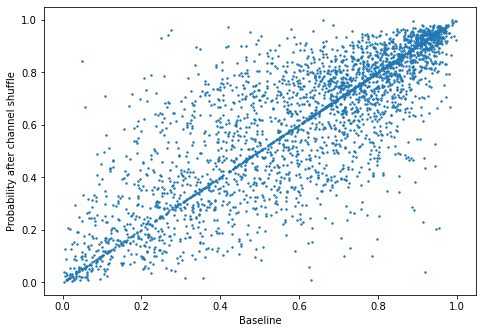

Normalized confusion matrix shuffled channels
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.7927425  0.00697837 0.         0.00209351 0.19818562
  0.        ]
 [0.00116279 0.0255814  0.63023256 0.00697674 0.1372093  0.19651163
  0.00232558]
 [0.         0.         0.         0.85714286 0.         0.14285714
  0.        ]
 [0.         0.         0.13114754 0.09836066 0.73770492 0.03278689
  0.        ]
 [0.         0.17169374 0.15777262 0.00348028 0.01856148 0.64733179
  0.00116009]
 [0.         0.         0.         0.         0.         0.
  1.        ]]


/home/aleksandra/anaconda3/envs/monai/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<AxesSubplot:title={'center':'Normalized confusion matrix  shuffled channels'}, xlabel='Predicted label', ylabel='True label'>

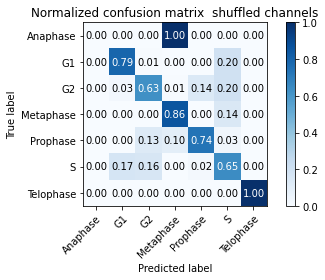

In [72]:
baselines = []
results_y = []
results_y_predicted = []
probs = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        baseline, probs_for_label, predicted_labels = channel_permutation(model, test_images, test_labels)
        #Tracer()()
        baselines += baseline
        probs += probs_for_label
        results_y += test_labels
        results_y_predicted += predicted_labels
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.asarray(baselines, dtype=np.float32), np.asarray(probs, dtype=np.float32), s=2)
ax.set_xlabel('Baseline')
ax.set_ylabel('Probability after channel shuffle')
plt.show()
plot_confusion_matrix(y_true=np.asarray(results_y, dtype=np.int), y_pred=np.asarray(results_y_predicted, dtype=np.int), classes=class_names, normalize=True, caption = " shuffled channels")

In [73]:
results = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
        results.append(pixel_permutation_per_channel(model, test_images, test_labels))

In [74]:
from itertools import groupby
from collections import defaultdict

def key_func(k): 
    return k['channel']

ress = [item for sublist in results for item in sublist]
ress = sorted(ress, key=key_func)
groups = []
y_per_channel = defaultdict(list)
y_predicted_per_channel = defaultdict(list)
for key, value in groupby(ress, key_func): 
    groups.append(list(value)) 
    y_per_channel[key] = [int(sub['true_label']) for sub in groups[0]]
    y_predicted_per_channel[key] = [int(sub['predicted_label']) for sub in groups[0]]

Normalized confusion matrixchannel 0
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 8.83461270e-01 1.39567341e-02 2.58199581e-02
  2.79134682e-03 7.32728542e-02 6.97836706e-04]
 [1.97674419e-02 2.93023256e-01 2.20930233e-01 1.33720930e-01
  3.25581395e-02 2.98837209e-01 1.16279070e-03]
 [1.42857143e-01 2.85714286e-01 0.00000000e+00 5.71428571e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.19672131e-02 1.47540984e-01 1.96721311e-01 1.96721311e-01
  1.31147541e-01 2.45901639e-01 0.00000000e+00]
 [1.16009281e-03 6.05568445e-01 3.82830626e-02 8.23665893e-02
  9.28074246e-03 2.63341067e-01 0.00000000e+00]
 [0.00000000e+00 6.66666667e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 3.33333333e-01]]
Normalized confusion matrixchannel 1
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 8.83461270e-01 1.39567341e-0

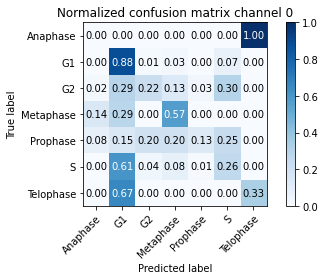

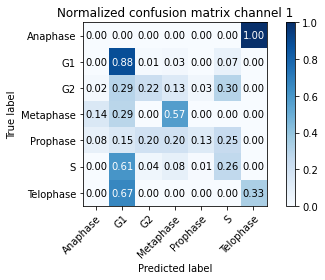

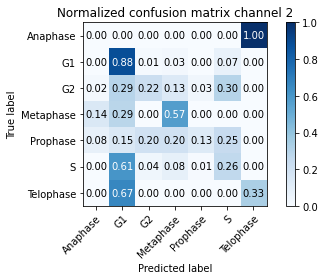

In [75]:
for (k,v), (k2,v2) in zip(y_per_channel.items(), y_predicted_per_channel.items()):
    plot_confusion_matrix(v, v2, classes=class_names, normalize=True, caption = "channel " + str(k))

In [44]:
from captum.attr import GuidedGradCam, DeepLift, Saliency, DeepLiftShap, GradientShap, InputXGradient, GradientShap, InputXGradient

In [45]:
test_sample = torch.load("/home/aleksandra/PycharmProjects/interpretable-multichannel-image-analysis/data/CellCycle/PreprocessedTestData/test_sample_0.pt")

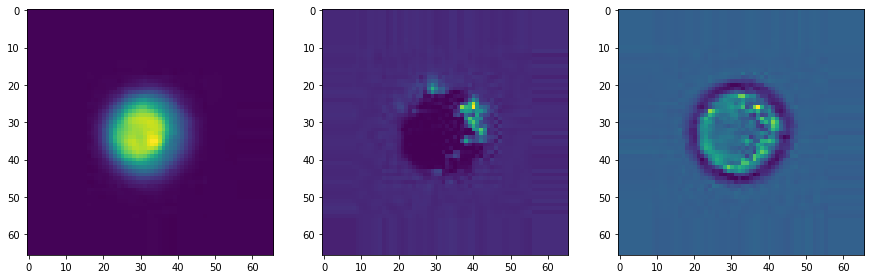

In [46]:
plot_heatmap_3_channels(test_sample[0])

In [47]:
dl= DeepLift(model)

In [51]:
heatmaps = dl.attribute(torch.unsqueeze(test_sample[0].float(), 0), target=int(test_sample[1]))

In [52]:
value = heatmaps[0]

In [53]:
value.shape

torch.Size([3, 66, 66])

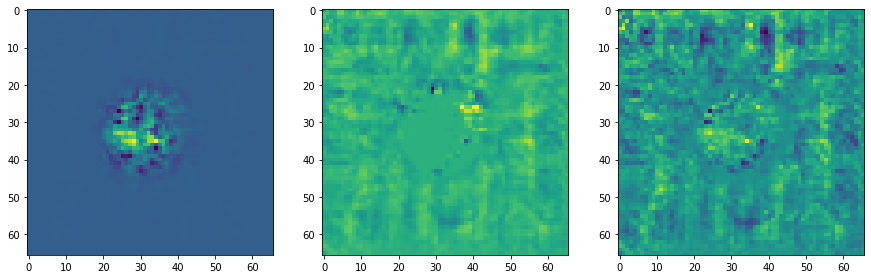

In [56]:
fig, axs = plt.subplots(1, len(value), figsize=(15, 6))
#fig.subplots_adjust(hspace=.5, wspace=.001)
axs = axs.ravel()
for (i,h) in zip(np.arange(len(value)),value):
    axs[i].imshow(h.detach().numpy())
fig.savefig("test_image")

In [ ]:
 fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,15))
    #plt.figure(figsize=(20,10))
    ax1.imshow(heatmap[0])
    ax2.imshow(heatmap[1])
    ax3.imshow(heatmap[2])

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

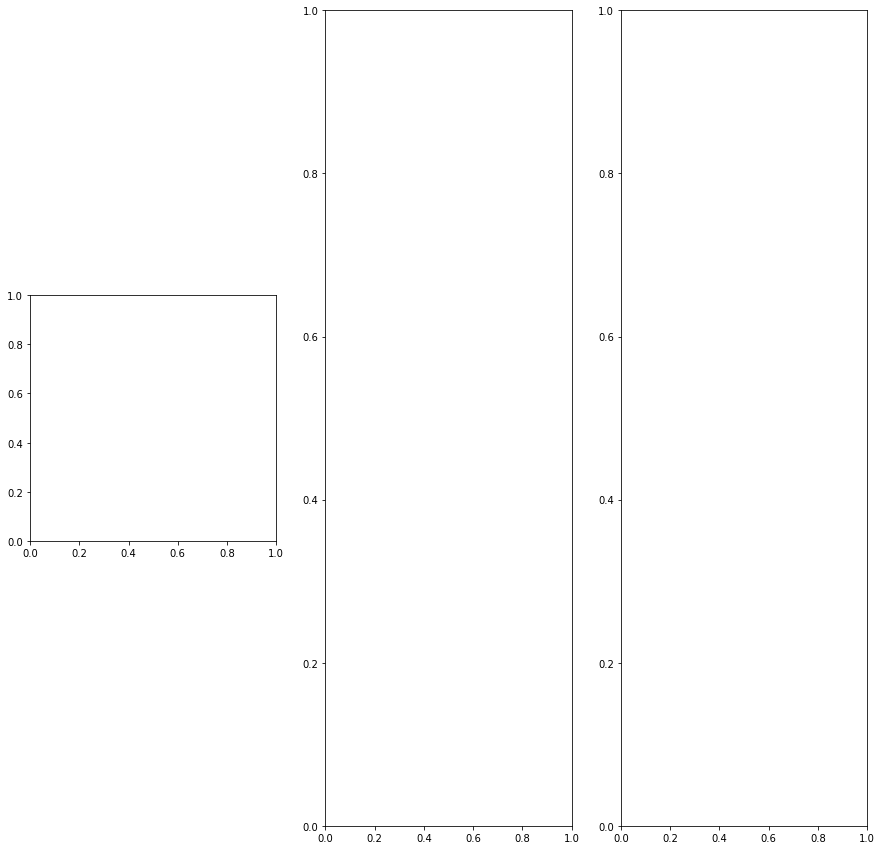

In [49]:
plot_heatmap_3_channels(heatmap)

In [ ]:
for test_data in test_loader:
    test_images, test_labels = test_data[0].to(device).float(), test_data[1].to(device)
    pred = model(test_images).argmax(dim=1)
    for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())